# Time Series Forecasting con Transformers de Hugging Face
# Dataset: Precio de Bitcoin en USD (BTC-USD)

In [1]:
!pip install darts --quiet
!pip install neuralforecast --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse, mape
from darts.models import TransformerModel, NHiTSModel, TFTModel
import random
import torch
import time

# Importaciones para Informer
from neuralforecast import NeuralForecast
from neuralforecast.models import Informer
from neuralforecast.losses.pytorch import MAE

/home/jorge/miniconda3/envs/darts-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-18 21:30:47,917	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-18 21:30:47,985	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
# Descargar y descomprimir el dataset desde Kaggle usando curl directo
zip_path = "bitcoin-historical-data.zip"
csv_filename = "btcusd_1-min_data.csv"

if not os.path.exists(csv_filename):
    if not os.path.exists(zip_path):
        !curl -L -o bitcoin-historical-data.zip \
            https://www.kaggle.com/api/v1/datasets/download/mczielinski/bitcoin-historical-data
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")

In [4]:
# Funciones auxiliares
def count_model_parameters(darts_model):
    """Cuenta los parámetros entrenables de un modelo Darts basado en PyTorch."""
    try:
        # La mayoría de los modelos Darts basados en PyTorch exponen el modelo subyacente en '.model'
        if hasattr(darts_model, 'model') and hasattr(darts_model.model, 'parameters'):
             return sum(p.numel() for p in darts_model.model.parameters() if p.requires_grad)
        elif hasattr(darts_model, '_model') and hasattr(darts_model._model, 'parameters'):
             return sum(p.numel() for p in darts_model._model.parameters() if p.requires_grad)
        else:
            print(f"Advertencia: No se pudo acceder a los parámetros para {type(darts_model)}. Verifique la estructura interna del modelo. Se devolverá 0.")
            return 0
    except Exception as e:
        print(f"Error al contar parámetros para {type(darts_model)}: {e}. Se devolverá 0.")
        return 0

# Cálculo de métricas
def calc_metrics(pred):
    return {
        'MAE': mae(test, pred),
        'MAPE': mape(test, pred),
        'RMSE': rmse(test, pred)
    }

In [5]:
# Función para crear y mostrar un gráfico de barras agrupadas para una métrica
def plot_custom_barchart(df, value_columns, value_short_names, title, y_label, lower_is_better=True, value_format=".4f", save_path=None, dpi=300):
    """
    Crea un gráfico de barras agrupadas para un conjunto personalizado de columnas.
    Args:
        df (pd.DataFrame): DataFrame con los resultados.
        value_columns (list): Lista de nombres de columnas del df que contienen los valores a graficar.
        value_short_names (list): Lista de nombres cortos para la leyenda (debe coincidir con value_columns).
        title (str): Título del gráfico.
        y_label (str): Etiqueta para el eje Y.
        lower_is_better (bool): True si valores más bajos son mejores (para métricas de error).
                                False si valores más altos son mejores (ej. para precisión).
        value_format (str): Formato para las anotaciones numéricas en las barras.
        save_path (str, optional): Ruta donde guardar la imagen. Si es None, no se guarda.
        dpi (int): Resolución de la imagen guardada. Default: 300.
    """
    if len(value_columns) != len(value_short_names):
        raise ValueError("value_columns y value_short_names deben tener la misma longitud.")
    
    # Crear un DataFrame temporal para el gráfico
    plot_df = df[['Ventana'] + value_columns].copy()
    plot_df.columns = ['Ventana'] + value_short_names
    plot_df.set_index('Ventana', inplace=True)
    
    # Determinar el colormap basado en si menor es mejor o no
    cmap_choice = 'viridis_r' if lower_is_better else 'viridis'
    ax = plot_df.plot(kind='bar', figsize=(12, 7), colormap=cmap_choice)
    
    plt.title(title, fontsize=16, pad=20)
    plt.ylabel(y_label, fontsize=12)
    plt.xlabel('Configuración de Ventana de Entrenamiento', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Modelo')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Añadir etiquetas de valor encima de las barras
    for p in ax.patches:
        ax.annotate(format(p.get_height(), value_format),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=8)
    
    plt.tight_layout()
    
    # Guardar la imagen si se proporciona una ruta
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Gráfico guardado en: {save_path}")
    
    plt.show()


In [6]:
def contar_parametros_informer(nf, model_name='Informer'):
    """
    Cuenta parámetros totales en modelo NeuralForecast Informer
    
    Args:
        nf: Objeto NeuralForecast entrenado
        model_name: Nombre del modelo a analizar (por defecto 'Informer')
    
    Returns:
        int: Número total de parámetros entrenables
    """
    import torch.nn as nn
    
    # Verificar que el modelo existe
    if not hasattr(nf, 'models') or not nf.models:
        raise ValueError("El modelo NeuralForecast no tiene modelos entrenados. Asegúrate de llamar .fit() primero.")
    
    # Buscar el modelo específico
    target_model = None
    for model in nf.models:
        if hasattr(model, '__class__') and model.__class__.__name__ == model_name:
            target_model = model
            break
    
    if target_model is None:
        available_models = [m.__class__.__name__ for m in nf.models if hasattr(m, '__class__')]
        raise ValueError(f"Modelo '{model_name}' no encontrado. Modelos disponibles: {available_models}")
    
    # Debug: mostrar atributos del modelo
    print(f"Analizando modelo: {model_name}")
    print(f"Tipo del modelo: {type(target_model)}")
    
    # Buscar el modelo PyTorch de manera más exhaustiva
    pytorch_model = None
    
    # Lista de posibles atributos donde puede estar el modelo
    possible_attrs = ['model', 'net', '_model', 'network', 'pytorch_model', 'lightning_module']
    
    for attr_name in possible_attrs:
        if hasattr(target_model, attr_name):
            candidate = getattr(target_model, attr_name)
            print(f"Probando atributo '{attr_name}': {type(candidate)}")
            
            # Verificar si es una instancia de nn.Module
            if isinstance(candidate, nn.Module):
                pytorch_model = candidate
                print(f"¡Encontrado modelo PyTorch en '{attr_name}'!")
                break
    
    # Si no encontramos nada, buscar en todos los atributos
    if pytorch_model is None:
        print("Buscando en todos los atributos...")
        for attr_name in dir(target_model):
            if not attr_name.startswith('_'):  # Evitar atributos privados
                try:
                    attr = getattr(target_model, attr_name)
                    if isinstance(attr, nn.Module):
                        pytorch_model = attr
                        print(f"¡Encontrado modelo PyTorch en '{attr_name}'!")
                        break
                except:
                    continue
    
    # Último intento: verificar si el target_model mismo es un nn.Module
    if pytorch_model is None and isinstance(target_model, nn.Module):
        pytorch_model = target_model
        print("El modelo objetivo es directamente un nn.Module")
    
    if pytorch_model is None:
        print(f"Atributos disponibles en {model_name}:")
        for attr in dir(target_model):
            if not attr.startswith('__'):
                try:
                    attr_type = type(getattr(target_model, attr))
                    print(f"  {attr}: {attr_type}")
                except:
                    print(f"  {attr}: <no accesible>")
        raise AttributeError(f"No se pudo encontrar el modelo PyTorch en el objeto {model_name}")
    
    # Contar parámetros entrenables
    try:
        total_params = sum(p.numel() for p in pytorch_model.parameters() if p.requires_grad)
        print(f"Parámetros entrenables en {model_name}: {total_params:,}")
        return total_params
    except Exception as e:
        print(f"Error al contar parámetros: {e}")
        print(f"Tipo del pytorch_model: {type(pytorch_model)}")
        raise

In [7]:
def plot_forecast_comparison_detailed(
    series_unscaled, 
    train_end, 
    test_unscaled, 
    predictions_dict, 
    metrics_dict,
    config_name, 
    window_size, 
    prediction_horizon,
    context_days_before_prediction=90
):
    """
    Genera un gráfico con dos paneles para comparar predicciones de modelos de time series.
    
    Panel superior: Vista completa del entrenamiento y predicciones
    Panel inferior: Vista ampliada de la zona de predicción
    """
    import matplotlib.patches as mpatches
    """
    Genera un gráfico con dos paneles para comparar predicciones de modelos de time series.
    
    Panel superior: Vista completa del entrenamiento y predicciones
    Panel inferior: Vista ampliada de la zona de predicción
    Leyenda unificada: En la parte inferior con organización horizontal
    
    Parameters:
    -----------
    series_unscaled : TimeSeries
        Serie temporal completa sin escalar
    train_end : pd.Timestamp
        Fecha de fin del entrenamiento
    test_unscaled : TimeSeries
        Datos reales del período de test
    predictions_dict : dict
        Diccionario con las predicciones de cada modelo
        Formato: {'modelo': TimeSeries_prediction}
    metrics_dict : dict
        Diccionario con las métricas de cada modelo
        Formato: {'modelo': {'MAE': value, 'MAPE': value, 'RMSE': value}}
    config_name : str
        Nombre de la configuración de ventana
    window_size : int
        Tamaño de la ventana en días
    prediction_horizon : int
        Horizonte de predicción en días
    context_days_before_prediction : int
        Días de contexto a mostrar antes de la predicción
    """
    
    # Configuración de colores para cada modelo
    colors = {
        'Transformer': '#0072B2',    # Azul oscuro
        'NHiTS': '#FF0000',         # Rojo
        'TFT': '#009E73',           # Verde oscuro
        'Informer': '#E69F00'       # Amarillo-ámbar
    }
    
    # Marcadores para cada modelo
    markers = {
        'Transformer': '^',
        'NHiTS': 's', 
        'TFT': 'x',
        'Informer': 'd'
    }
    
    # Calcular el inicio del tramo de entrenamiento a graficar
    plot_train_start_date = train_end - pd.Timedelta(days=context_days_before_prediction)
    plot_train_start_date = max(plot_train_start_date, series_unscaled.start_time())
    
    # Crear figura con dos paneles
    plt.figure(figsize=(16, 12))
    
    # =================== PANEL SUPERIOR ===================
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    
    # Graficar datos históricos de entrenamiento (contexto)
    training_plot_slice = series_unscaled.slice(plot_train_start_date, train_end)
    ax1.plot(training_plot_slice.time_index, training_plot_slice.values().flatten(), 
             label='Entrenamiento (contexto)', color='gray', linewidth=1.5, alpha=0.7)
    
    # Graficar valores reales del período de prueba
    ax1.plot(test_unscaled.time_index, test_unscaled.values().flatten(), 
             label='Valores Reales (Test)', color='black', linewidth=2.5, marker='o', markersize=3)
    
    # Graficar predicciones de cada modelo en el panel superior
    for model_name, prediction in predictions_dict.items():
        if model_name in colors:
            mae_value = metrics_dict[model_name]['MAE']
            ax1.plot(prediction.time_index, prediction.values().flatten(),
                    label=f'{model_name} (MAE: {mae_value:.4f})',
                    color=colors[model_name], 
                    linestyle='--', 
                    linewidth=2,
                    marker=markers[model_name], 
                    markersize=4,
                    alpha=0.8)
    
    # Línea vertical para marcar fin de entrenamiento
    ax1.axvline(x=train_end, color='orange', linestyle=':', linewidth=2, alpha=0.8)
    ax1.text(train_end, ax1.get_ylim()[0] + (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.02, 
             'Fin Entrenamiento', rotation=90, verticalalignment='bottom', fontsize=10)
    
    # Configuración del panel superior
    ax1.set_title(f'Predicción a {prediction_horizon} días | Ventana: {config_name} ({window_size} días)', 
                  fontsize=16, pad=20)
    ax1.set_ylabel('Precio BTC (USD)', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    
    # =================== PANEL INFERIOR (ZOOM) ===================
    ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)
    
    # Graficar valores reales del período de prueba (zoom)
    ax2.plot(test_unscaled.time_index, test_unscaled.values().flatten(), 
             label='Valores Reales (Test)', color='black', linewidth=3, 
             marker='o', markersize=6, zorder=10)
    
    # Graficar predicciones de cada modelo en el panel inferior (zoom)
    for model_name, prediction in predictions_dict.items():
        if model_name in colors:
            mae_value = metrics_dict[model_name]['MAE']
            mape_value = metrics_dict[model_name]['MAPE']
            ax2.plot(prediction.time_index, prediction.values().flatten(),
                    label=f'{model_name} (MAE: {mae_value:.4f}, MAPE: {mape_value:.2f}%)',
                    color=colors[model_name], 
                    linestyle='--', 
                    linewidth=2.5,
                    marker=markers[model_name], 
                    markersize=6,
                    alpha=0.9)
    
    # Configuración del panel inferior
    ax2.set_title(f'Detalle de Predicciones - Período de Test ({prediction_horizon} días)', 
                  fontsize=14, pad=15)
    ax2.set_ylabel('Precio BTC (USD)', fontsize=12)
    ax2.set_xlabel('Fecha', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    
    # Ajustar límites del eje Y para el zoom
    all_values = []
    all_values.extend(test_unscaled.values().flatten())
    for prediction in predictions_dict.values():
        all_values.extend(prediction.values().flatten())
    
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    padding = (max_val - min_val) * 0.05
    ax2.set_ylim(min_val - padding, max_val + padding)
    
    # Rotar etiquetas de fecha en el panel inferior
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # Crear leyenda unificada en la parte inferior
    handles = []
    labels = []
    
    # Elementos base
    train_patch = mpatches.Patch(color='gray', alpha=0.7, label='Entrenamiento (contexto)')
    test_patch = mpatches.Patch(color='black', label='Valores Reales (Test)')
    separator_patch = mpatches.Patch(color='orange', alpha=0.8, label='Fin Entrenamiento')
    
    handles.extend([train_patch, test_patch, separator_patch])
    labels.extend(['Entrenamiento (contexto)', 'Valores Reales (Test)', 'Fin Entrenamiento'])
    
    # Predicciones de cada modelo
    for model_name in ['Transformer', 'NHiTS', 'TFT', 'Informer']:
        if model_name in predictions_dict and model_name in colors:
            mae_value = metrics_dict[model_name]['MAE']
            pred_patch = mpatches.Patch(color=colors[model_name], 
                                      label=f'{model_name} (MAE: {mae_value:.4f})')
            handles.append(pred_patch)
            labels.append(f'{model_name} (MAE: {mae_value:.4f})')
    
    # Colocar leyenda debajo del gráfico con múltiples columnas
    plt.figlegend(handles, labels, loc='lower center', ncol=4, 
                  bbox_to_anchor=(0.5, 0), frameon=True, fontsize=10,
                  fancybox=True, shadow=True)
    
    # Ajustar layout para dar espacio a la leyenda
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Espacio para la leyenda inferior
    
    # Guardar figura
    filename = f'prediccion_bitcoin_{config_name}_{prediction_horizon}dias.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return filename

Seed set to 1
/home/jorge/miniconda3/envs/darts-env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion  


Entrenando con ventana de 1_año (365 días)

Entrenando modelos con ventana 1_año...
Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 53.92it/s, train_loss=0.000835]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 53.73it/s, train_loss=0.000835]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Transformer entrenado en: 18.32s, Parámetros: 549,386



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 248 K  | train
-------------------------------------------------------------
240 K     Trainable params
7.7 K     Non-trainable params
248 K     Total params
0.994     Total estimated model params size (MB)
84        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 120.61it/s, train_loss=0.000529]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 119.29it/s, train_loss=0.000529]
NHiTS entrenado en: 7.7s, Parámetros: 240,818


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.5 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_cont

Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 33.82it/s, train_loss=0.0912]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 33.74it/s, train_loss=0.0912]
TFT entrenado en: 29.01s, Parámetros: 279,727
Entrenando Informer...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 96     | train
4 | dec_embedding | DataEmbedding | 96     | train
5 | encoder       | TransEncoder  | 20.3 K | train
6 | decoder       | TransDecoder  | 12.9 K | train
--------------------------------------------------------
33.4 K    Trainable params
0         Non-trainable params
33.4 K    Total params
0.134     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s, v_num=28, train_loss_step=1.250, train_loss_epoch=1.250, valid_loss=2.51e+3]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s, v_num=28, train_loss_step=1.250, train_loss_epoch=1.250, valid_loss=2.51e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analizando modelo: Informer
Tipo del modelo: <class 'neuralforecast.models.informer.Informer'>
Buscando en todos los atributos...
¡Encontrado modelo PyTorch en 'dec_embedding'!
Parámetros entrenables en Informer: 96
Informer entrenado en: 13.17s, Parámetros: 96
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.16it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.97it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.92it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.44it/s]


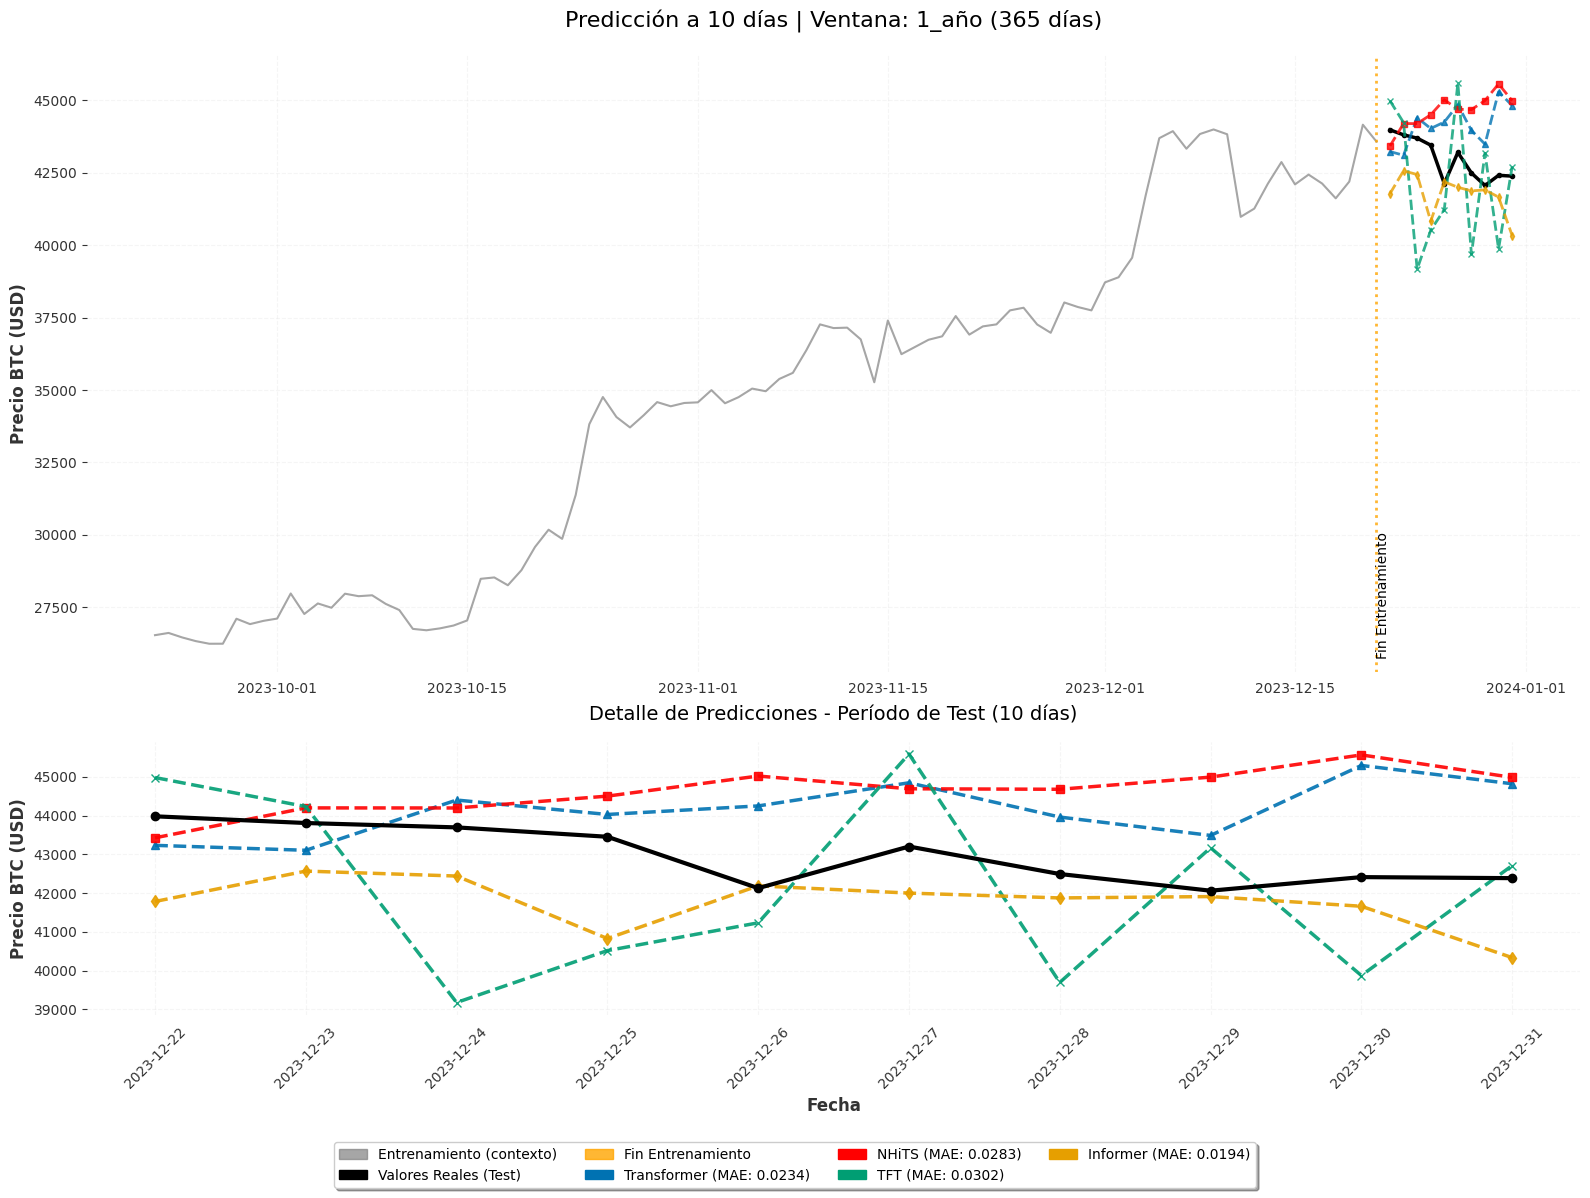

Seed set to 1
/home/jorge/miniconda3/envs/darts-env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positi

Gráfico guardado como: prediccion_bitcoin_1_año_10dias.png

Entrenando con ventana de 6_meses (180 días)

Entrenando modelos con ventana 6_meses...
Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 50.67it/s, train_loss=0.00228]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 50.20it/s, train_loss=0.00228]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 248 K  | train
-------------------------------------------------------------
240 K     Trainable params
7.7 K     Non-trainable params
248 K     Total params
0.994     Total estimated model params size (MB)
84        Modules in train mode
0         Modules in eval mode


Transformer entrenado en: 7.25s, Parámetros: 549,386
Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 112.03it/s, train_loss=0.000885]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 109.50it/s, train_loss=0.000885]
NHiTS entrenado en: 3.8s, Parámetros: 240,818


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.5 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_cont

Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 35.25it/s, train_loss=0.0988]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 35.02it/s, train_loss=0.0988]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TFT entrenado en: 11.81s, Parámetros: 279,727
Entrenando Informer...



  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 96     | train
4 | dec_embedding | DataEmbedding | 96     | train
5 | encoder       | TransEncoder  | 20.3 K | train
6 | decoder       | TransDecoder  | 12.9 K | train
--------------------------------------------------------
33.4 K    Trainable params
0         Non-trainable params
33.4 K    Total params
0.134     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 20.64it/s, v_num=30, train_loss_step=1.360, train_loss_epoch=1.360, valid_loss=1.01e+3]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s, v_num=30, train_loss_step=1.360, train_loss_epoch=1.360, valid_loss=1.01e+3]
Analizando modelo: Informer
Tipo del modelo: <class 'neuralforecast.models.informer.Informer'>
Buscando en todos los atributos...
¡Encontrado modelo PyTorch en 'dec_embedding'!
Parámetros entrenables en Informer: 96
Informer entrenado en: 14.24s, Parámetros: 96


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.30it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.14it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.79it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.87it/s]


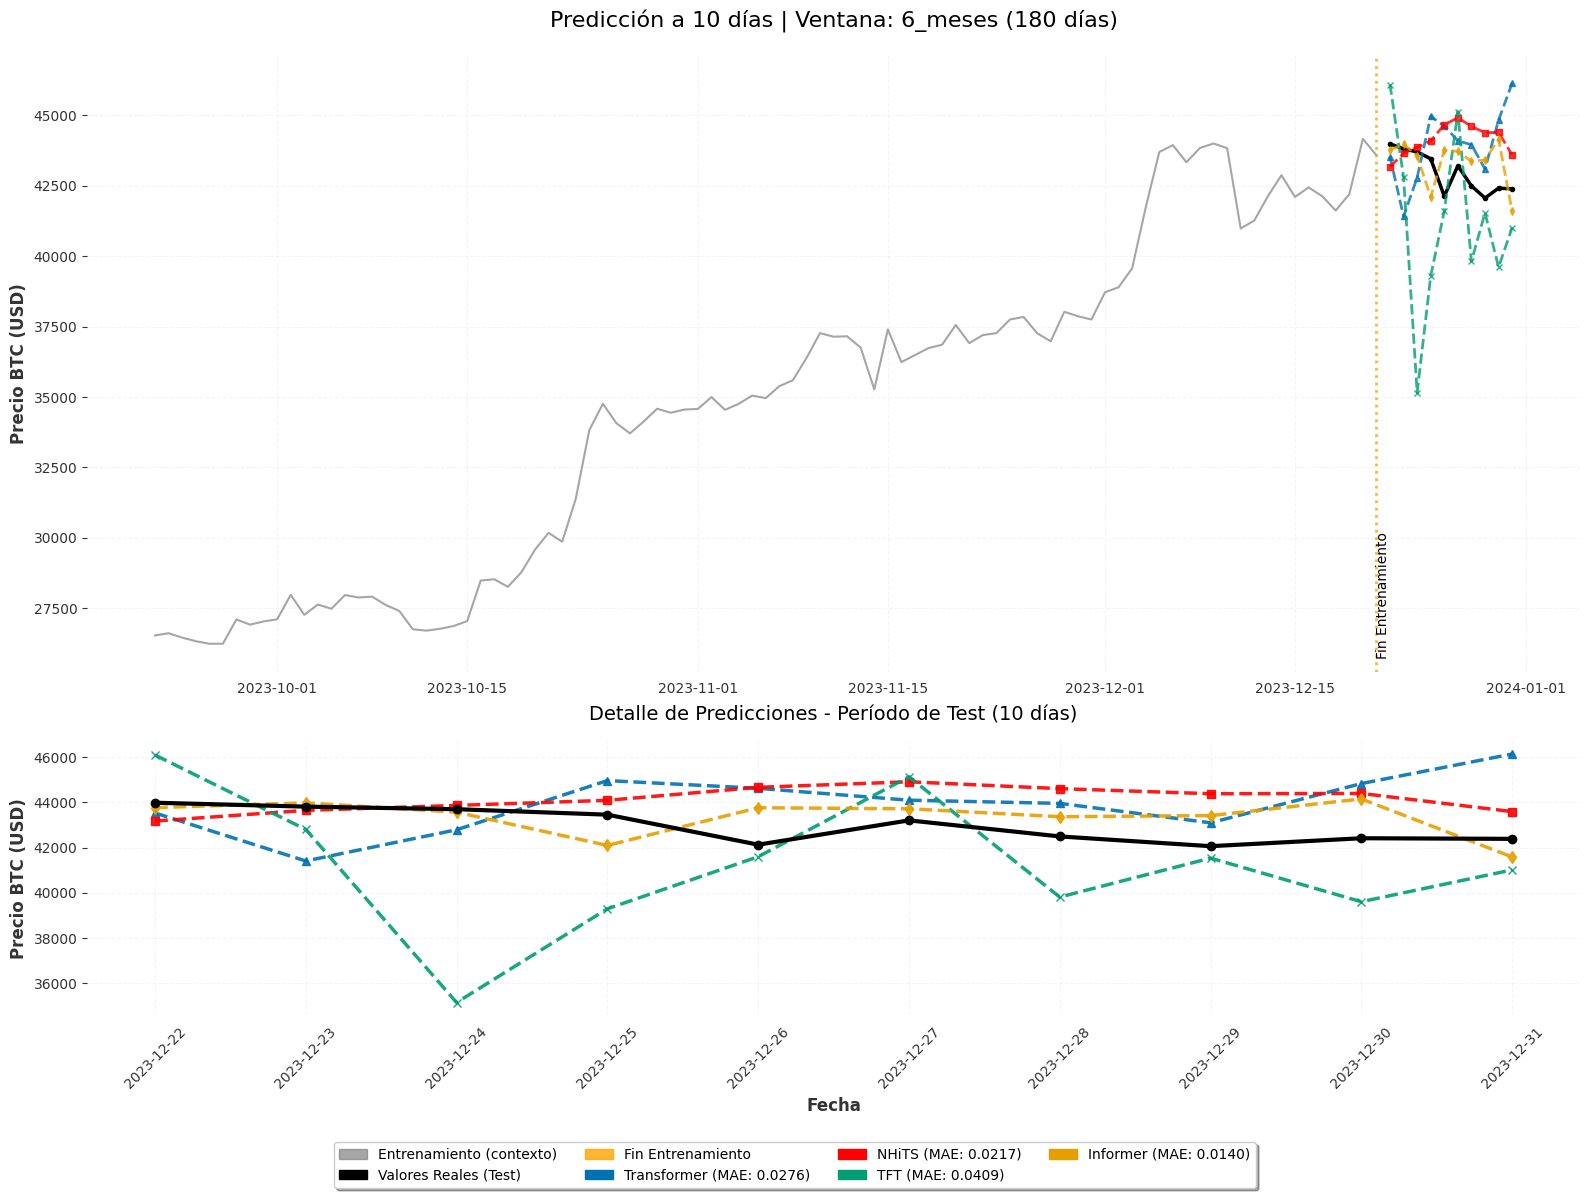

Seed set to 1
/home/jorge/miniconda3/envs/darts-env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positi

Gráfico guardado como: prediccion_bitcoin_6_meses_10dias.png

Entrenando con ventana de 3_meses (90 días)

Entrenando modelos con ventana 3_meses...
Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 48.32it/s, train_loss=0.00607]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 47.30it/s, train_loss=0.00607]
Transformer entrenado en: 3.69s, Parámetros: 549,386


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 227 K  | train
-------------------------------------------------------------
223 K     Trainable params
3.9 K     Non-trainable params
227 K     Total params
0.909     Total estimated model params size (MB)
84        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 106.18it/s, train_loss=0.000855]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 101.98it/s, train_loss=0.000855]
NHiTS entrenado en: 2.06s, Parámetros: 223,338


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.5 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_cont

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 43.43it/s, train_loss=0.171]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 42.69it/s, train_loss=0.171]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TFT entrenado en: 4.93s, Parámetros: 279,727
Entrenando Informer...



  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 96     | train
4 | dec_embedding | DataEmbedding | 96     | train
5 | encoder       | TransEncoder  | 20.3 K | train
6 | decoder       | TransDecoder  | 12.9 K | train
--------------------------------------------------------
33.4 K    Trainable params
0         Non-trainable params
33.4 K    Total params
0.134     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s, v_num=32, train_loss_step=1.480, train_loss_epoch=1.480, valid_loss=810.0]  

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 22.96it/s, v_num=32, train_loss_step=1.480, train_loss_epoch=1.480, valid_loss=810.0]

GPU available: True (cuda), used: True



Analizando modelo: Informer
Tipo del modelo: <class 'neuralforecast.models.informer.Informer'>
Buscando en todos los atributos...
¡Encontrado modelo PyTorch en 'dec_embedding'!
Parámetros entrenables en Informer: 96
Informer entrenado en: 12.76s, Parámetros: 96


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.23it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.23it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.57it/s]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.21it/s]


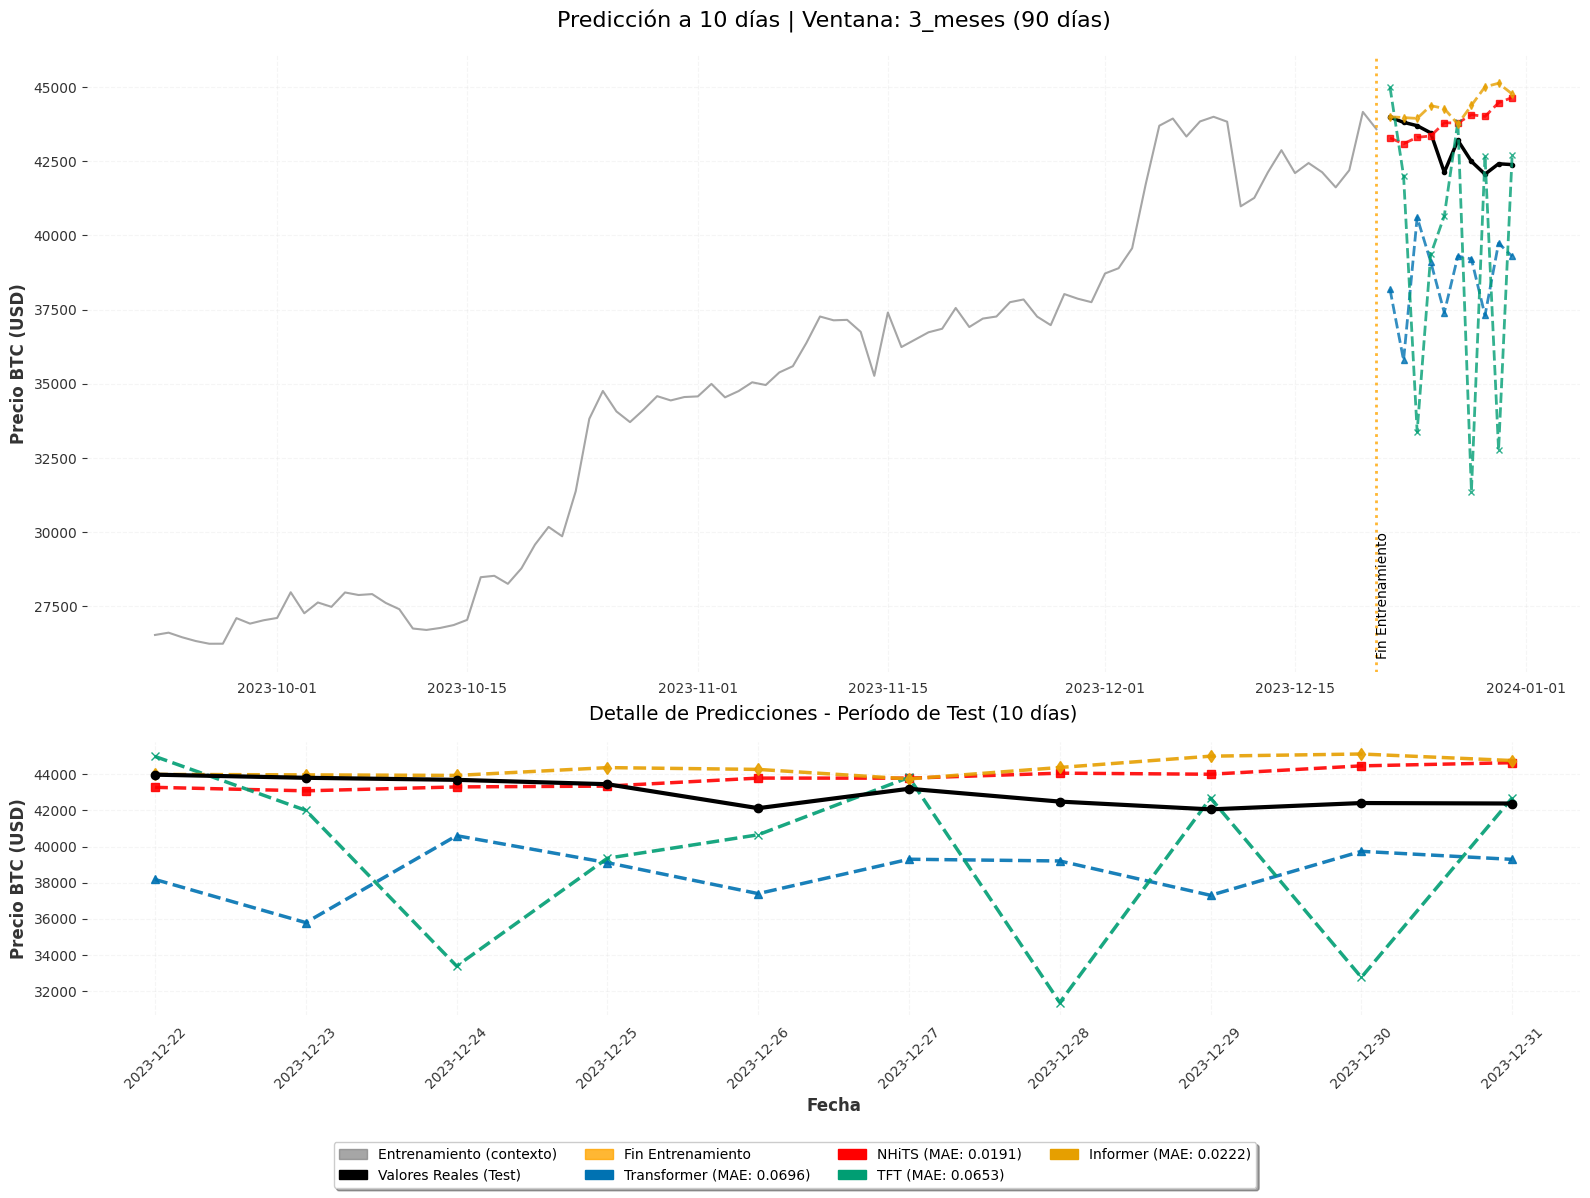

Gráfico guardado como: prediccion_bitcoin_3_meses_10dias.png

Resultados Comparativos:
| Ventana   |   Días |   Transformer_MAE |   Transformer_MAPE |   Transformer_RMSE |   Transformer_TrainTime_s |   Transformer_Params |   NHiTS_MAE |   NHiTS_MAPE |   NHiTS_RMSE |   NHiTS_TrainTime_s |   NHiTS_Params |   TFT_MAE |   TFT_MAPE |   TFT_RMSE |   TFT_TrainTime_s |   TFT_Params |   Informer_MAE |   Informer_MAPE |   Informer_RMSE |   Informer_TrainTime_s |   Informer_Params |
|:----------|-------:|------------------:|-------------------:|-------------------:|--------------------------:|---------------------:|------------:|-------------:|-------------:|--------------------:|---------------:|----------:|-----------:|-----------:|------------------:|-------------:|---------------:|----------------:|----------------:|-----------------------:|------------------:|
| 1_año     |    365 |            0.0234 |             3.9042 |             0.0264 |                     18.32 |               549386

In [8]:
# Establecer todas las semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Fechas fijas para el análisis
START_DATE = '2020-01-01'
END_DATE = '2023-12-31'
PREDICTION_HORIZON = 10  # 10 días hacia adelante

# Cargar y preparar datos
df = pd.read_csv("btcusd_1-min_data.csv")
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.rename(columns={'Close': 'price'})
df = df[['date', 'price']].dropna()
df = df[(df['date'] >= START_DATE) & (df['date'] <= END_DATE)]
df_daily = df.set_index('date').resample('D').last().ffill()

# Convertir a serie temporal para Darts
series = TimeSeries.from_dataframe(df_daily.reset_index(), 'date', 'price')
scaler = Scaler()
series_scaled = scaler.fit_transform(series)
series_unscaled = scaler.inverse_transform(series_scaled)

# Preparar datos para NeuralForecast - formato requerido
df_neuralforecast = df_daily.reset_index()
df_neuralforecast['unique_id'] = 'BTC'  # Identificador único requerido
df_neuralforecast = df_neuralforecast.rename(columns={'date': 'ds', 'price': 'y'})
df_neuralforecast = df_neuralforecast[['unique_id', 'ds', 'y']]

# Configuraciones de ventanas históricas a probar
WINDOW_CONFIGS = {
    '1_año': 365,
    '6_meses': 180,
    '3_meses': 90,
}

results = []

for config_name, window_size in WINDOW_CONFIGS.items():
    print(f"\n{'='*50}")
    print(f"Entrenando con ventana de {config_name} ({window_size} días)")
    print(f"{'='*50}")

    # Definir períodos de entrenamiento y prueba
    train_end = series.time_index[-PREDICTION_HORIZON-1]
    train_start = train_end - pd.Timedelta(days=window_size)
    test_start = train_end + pd.Timedelta(days=1)
    test_end = test_start + pd.Timedelta(days=PREDICTION_HORIZON-1)

    # Crear subseries para Darts
    train = series_scaled.slice(train_start, train_end)
    test = series_scaled.slice(test_start, test_end)

    # Preparar datos para NeuralForecast
    nf_train_df = df_neuralforecast[
        (df_neuralforecast['ds'] >= train_start) & 
        (df_neuralforecast['ds'] <= train_end)
    ].copy()
    
    nf_test_df = df_neuralforecast[
        (df_neuralforecast['ds'] >= test_start) & 
        (df_neuralforecast['ds'] <= test_end)
    ].copy()

    # Configuración común de modelos Darts
    common_args = {
        'input_chunk_length': min(60, window_size//3),
        'output_chunk_length': PREDICTION_HORIZON,
        'random_state': SEED,
        'n_epochs': 100,
        'batch_size': 32,
        'optimizer_kwargs': {'lr': 1e-3},
        'model_name': f'{config_name}_model'
    }

    # Inicializar modelos Darts
    transformer = TransformerModel(
        **common_args,
        d_model=64,
        nhead=4,
        num_encoder_layers=3,
        num_decoder_layers=3,
        dropout=0.1
    )

    nhits = NHiTSModel(
        **common_args,
        num_blocks=2,
        num_layers=3,
        layer_widths=128,
        dropout=0.1
    )

    tft = TFTModel(
        **common_args,
        hidden_size=64,
        lstm_layers=2,
        dropout=0.1,
        add_relative_index=True
    )

    # Configurar modelo Informer
    informer_model = Informer(
        h=PREDICTION_HORIZON,
        input_size=min(60, window_size//3),
        hidden_size=32,
        conv_hidden_size=64,
        n_head=2,
        loss=MAE(),
        scaler_type='standard',
        learning_rate=1e-5,
        max_steps=500,
        val_check_steps=25,
        early_stop_patience_steps=5,
        encoder_layers=2,
        decoder_layers=1,
        dropout=0.3,
        batch_size=8
    )

    nf = NeuralForecast(
        models=[informer_model],
        freq='D'
    )

    # Entrenamiento y medición de tiempo
    print(f"\nEntrenando modelos con ventana {config_name}...")

    # Transformer
    start_time_trans = time.time()
    transformer.fit(train, verbose=True)
    end_time_trans = time.time()
    train_time_trans = round(end_time_trans - start_time_trans, 2)
    params_trans = count_model_parameters(transformer)
    print(f"Transformer entrenado en: {train_time_trans}s, Parámetros: {params_trans:,}")

    # NHiTS
    start_time_nhits = time.time()
    nhits.fit(train, verbose=True)
    end_time_nhits = time.time()
    train_time_nhits = round(end_time_nhits - start_time_nhits, 2)
    params_nhits = count_model_parameters(nhits)
    print(f"NHiTS entrenado en: {train_time_nhits}s, Parámetros: {params_nhits:,}")

    # TFT
    start_time_tft = time.time()
    tft.fit(train, verbose=True)
    end_time_tft = time.time()
    train_time_tft = round(end_time_tft - start_time_tft, 2)
    params_tft = count_model_parameters(tft)
    print(f"TFT entrenado en: {train_time_tft}s, Parámetros: {params_tft:,}")

    # Informer
    start_time_informer = time.time()
    print("Entrenando Informer...")
    nf.fit(df=nf_train_df, val_size=min(12, len(nf_train_df)//5))
    end_time_informer = time.time()
    train_time_informer = round(end_time_informer - start_time_informer, 2)
    params_informer = contar_parametros_informer(nf)
    print(f"Informer entrenado en: {train_time_informer}s, Parámetros: {params_informer:,}")

    # Predicción
    pred_trans = transformer.predict(n=PREDICTION_HORIZON)
    pred_nhits = nhits.predict(n=PREDICTION_HORIZON)
    pred_tft = tft.predict(n=PREDICTION_HORIZON)

    # Predicción Informer
    informer_forecasts = nf.predict(futr_df=nf_test_df[['unique_id', 'ds']])
    informer_values = informer_forecasts['Informer'].values
    
    # Convertir predicción de Informer a TimeSeries y escalar para comparación
    temp_informer_original = TimeSeries.from_times_and_values(
        times=test.time_index,
        values=informer_values
    )
    pred_informer_scaled = scaler.transform(temp_informer_original)

    # Cálculo de métricas
    metrics_trans = calc_metrics(pred_trans)
    metrics_nhits = calc_metrics(pred_nhits)
    metrics_tft = calc_metrics(pred_tft)
    metrics_informer = calc_metrics(pred_informer_scaled)

    # Almacenar resultados
    results.append({
        'Ventana': config_name,
        'Días': window_size,
        'Transformer_MAE': round(metrics_trans['MAE'], 4),
        'Transformer_MAPE': round(metrics_trans['MAPE'], 4),
        'Transformer_RMSE': round(metrics_trans['RMSE'], 4),
        'Transformer_TrainTime_s': train_time_trans,
        'Transformer_Params': params_trans,
        'NHiTS_MAE': round(metrics_nhits['MAE'], 4),
        'NHiTS_MAPE': round(metrics_nhits['MAPE'], 4),
        'NHiTS_RMSE': round(metrics_nhits['RMSE'], 4),
        'NHiTS_TrainTime_s': train_time_nhits,
        'NHiTS_Params': params_nhits,
        'TFT_MAE': round(metrics_tft['MAE'], 4),
        'TFT_MAPE': round(metrics_tft['MAPE'], 4),
        'TFT_RMSE': round(metrics_tft['RMSE'], 4),
        'TFT_TrainTime_s': train_time_tft,
        'TFT_Params': params_tft,
        'Informer_MAE': round(metrics_informer['MAE'], 4),
        'Informer_MAPE': round(metrics_informer['MAPE'], 4),
        'Informer_RMSE': round(metrics_informer['RMSE'], 4),
        'Informer_TrainTime_s': train_time_informer,
        'Informer_Params': params_informer,
    })

    # Preparar datos para visualización
    test_unscaled = scaler.inverse_transform(test)
    pred_trans_unscaled = scaler.inverse_transform(pred_trans)
    pred_nhits_unscaled = scaler.inverse_transform(pred_nhits)
    pred_tft_unscaled = scaler.inverse_transform(pred_tft)
    pred_informer_unscaled = temp_informer_original  # Ya está en escala original

    # NUEVA VISUALIZACIÓN DETALLADA
    predictions_dict = {
        'Transformer': pred_trans_unscaled,
        'NHiTS': pred_nhits_unscaled,
        'TFT': pred_tft_unscaled,
        'Informer': pred_informer_unscaled
    }

    metrics_dict = {
        'Transformer': metrics_trans,
        'NHiTS': metrics_nhits,
        'TFT': metrics_tft,
        'Informer': metrics_informer
    }

    # Llamar a la función de graficación detallada
    saved_filename = plot_forecast_comparison_detailed(
        series_unscaled=series_unscaled,
        train_end=train_end,
        test_unscaled=test_unscaled,
        predictions_dict=predictions_dict,
        metrics_dict=metrics_dict,
        config_name=config_name,
        window_size=window_size,
        prediction_horizon=PREDICTION_HORIZON,
        context_days_before_prediction=90
    )

    print(f"Gráfico guardado como: {saved_filename}")

# Resultados comparativos
results_df = pd.DataFrame(results)
print("\nResultados Comparativos:")
print(results_df.to_markdown(index=False))

Generando gráfico de barras para MAE...
Gráfico guardado en: comparacion_modelos_por_MAE.png


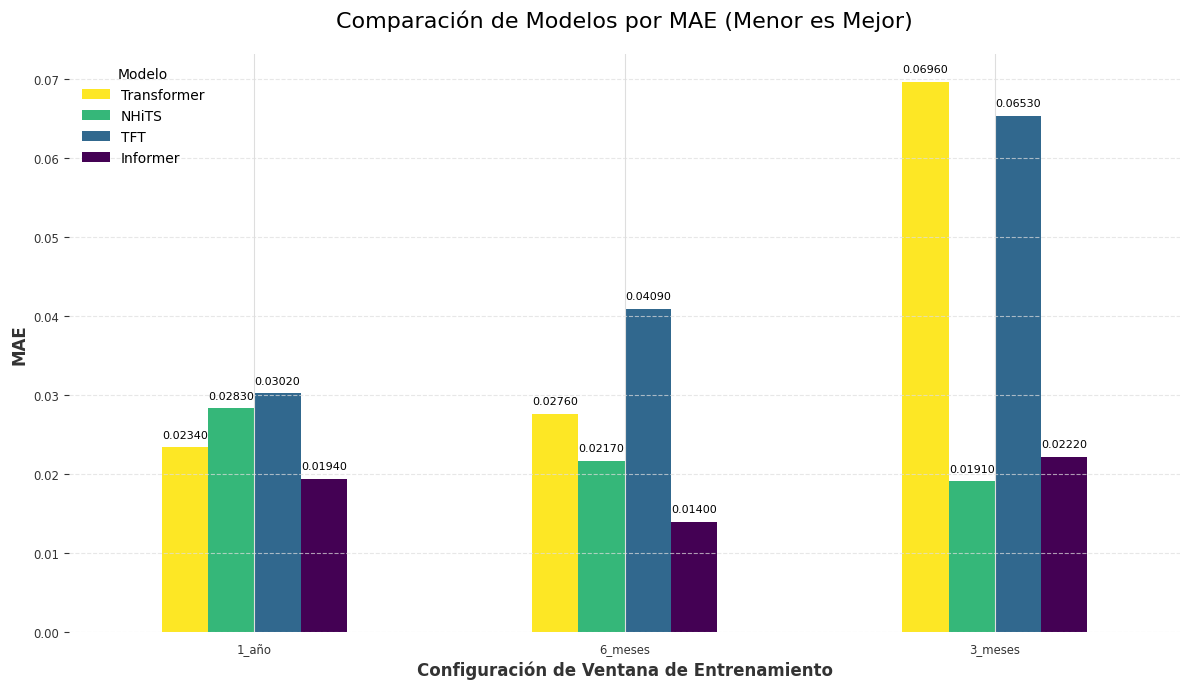

Generando gráfico de barras para MAPE...
Gráfico guardado en: comparacion_modelos_por_MAPE.png


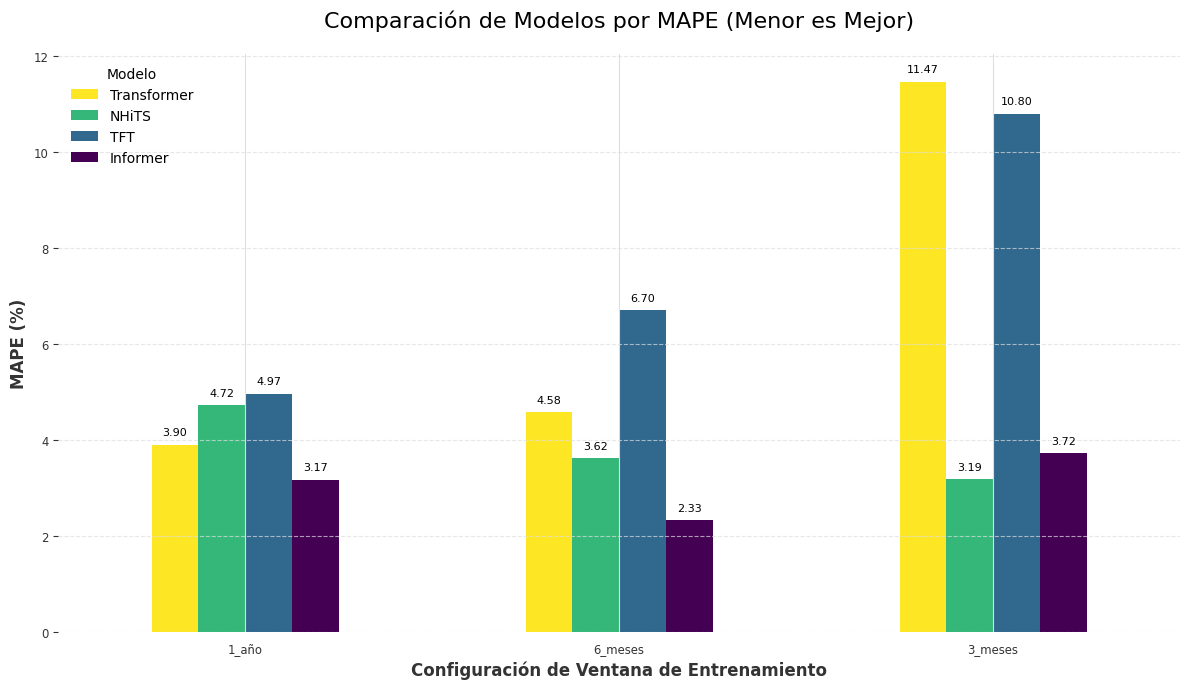

Generando gráfico de barras para RMSE...
Gráfico guardado en: comparacion_modelos_por_RMSE.png


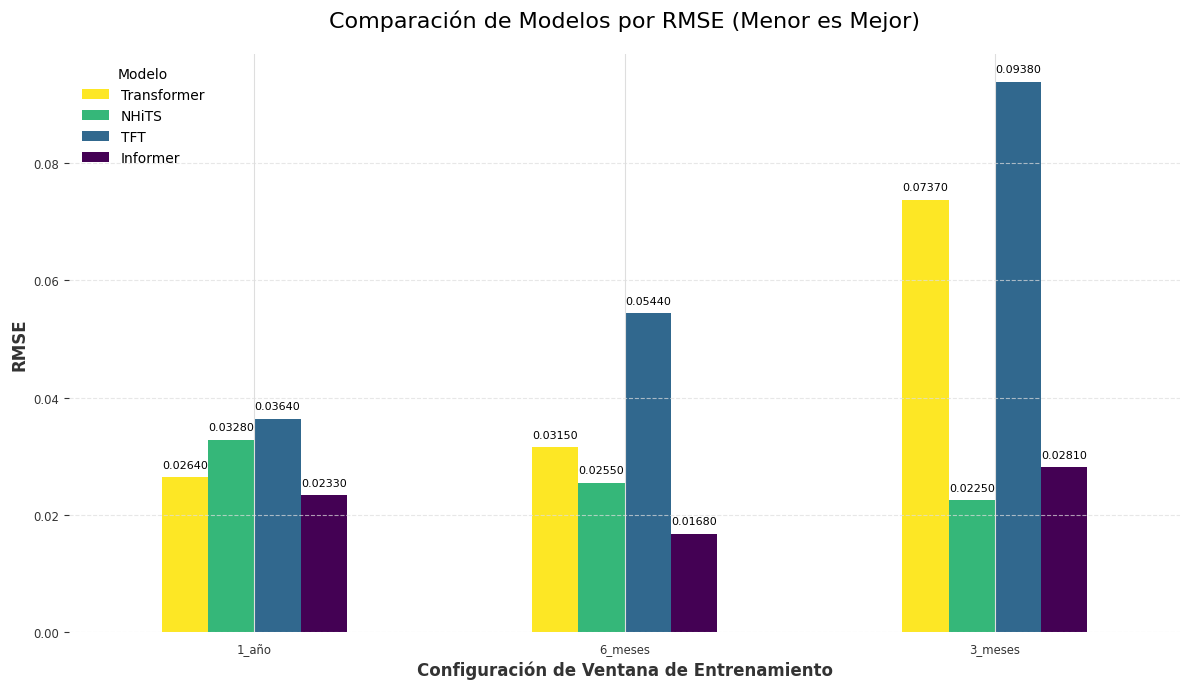


Generando gráfico de barras para Tiempos de Entrenamiento...
Gráfico guardado en: comparacion_de_tiempo_entrenamiento.png


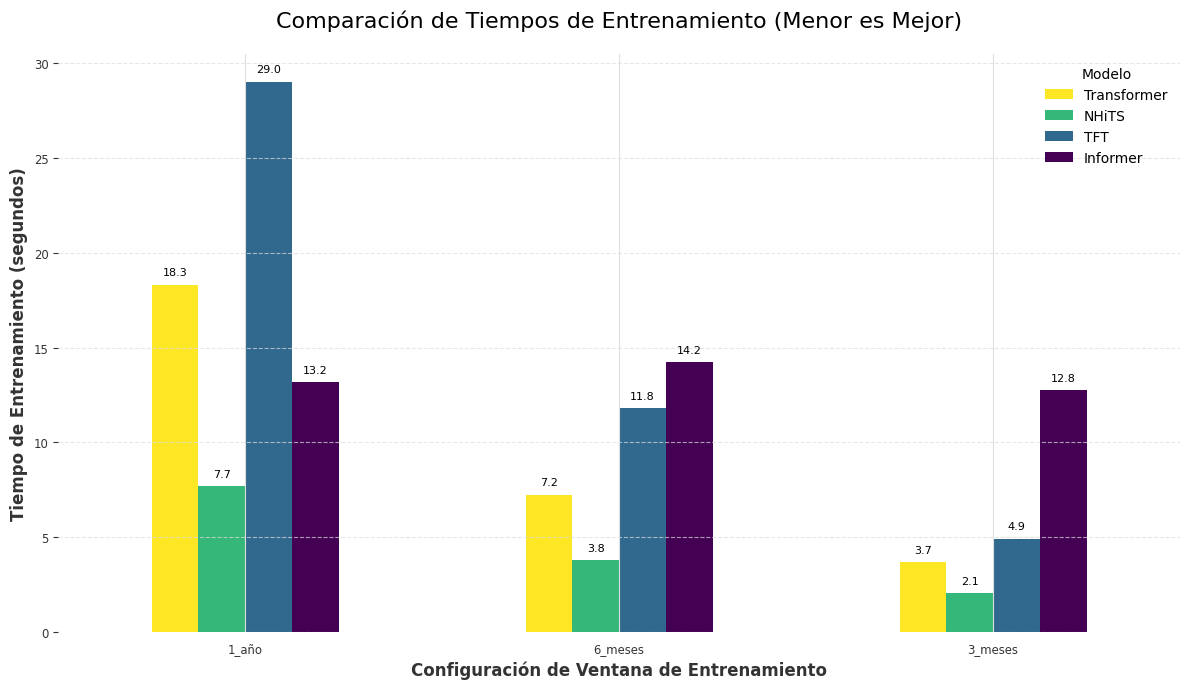


Generando gráfico de barras para Tamaño de Modelos...
Gráfico guardado en: comparacion_de_tamano_de_modelos.png


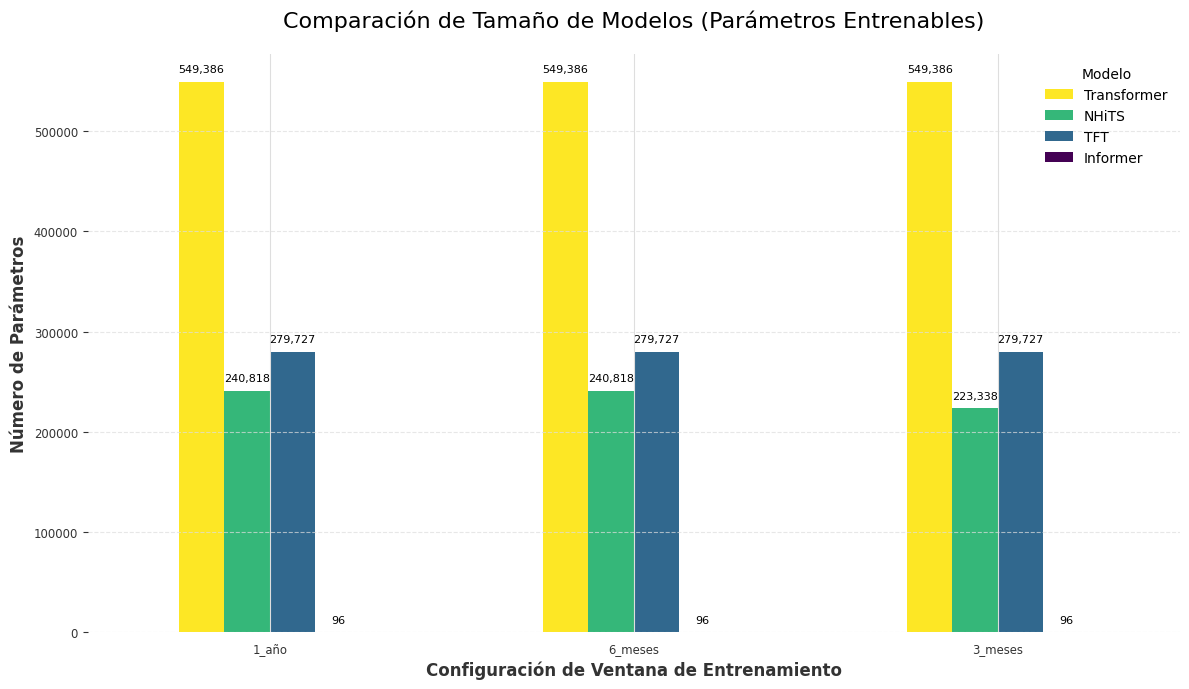

In [9]:
metrics_to_plot = [
    {'name': 'MAE', 'suffix': '', 'format': ".5f", 'lower_is_better': True},
    {'name': 'MAPE', 'suffix': ' (%)', 'format': ".2f", 'lower_is_better': True},
    {'name': 'RMSE', 'suffix': '', 'format': ".5f", 'lower_is_better': True}
]

for metric_info in metrics_to_plot:
    metric_base_name = metric_info['name']
    print(f"Generando gráfico de barras para {metric_base_name}...")
    cols_to_plot = [f'Transformer_{metric_base_name}', f'NHiTS_{metric_base_name}', 
                    f'TFT_{metric_base_name}', f'Informer_{metric_base_name}']
    short_names = ['Transformer', 'NHiTS', 'TFT', 'Informer']
    filename = f'comparacion_modelos_por_{metric_base_name}.png'
    plot_custom_barchart(results_df,
                         cols_to_plot,
                         short_names,
                         title=f'Comparación de Modelos por {metric_base_name} (Menor es Mejor)',
                         y_label=f'{metric_base_name}{metric_info["suffix"]}',
                         lower_is_better=metric_info['lower_is_better'],
                         value_format=metric_info['format'],
                         save_path=filename)

print("\nGenerando gráfico de barras para Tiempos de Entrenamiento...")
time_cols = ['Transformer_TrainTime_s', 'NHiTS_TrainTime_s', 'TFT_TrainTime_s', 'Informer_TrainTime_s']
time_short_names = ['Transformer', 'NHiTS', 'TFT', 'Informer']
filename = f'comparacion_de_tiempo_entrenamiento.png'
plot_custom_barchart(results_df,
                     time_cols,
                     time_short_names,
                     title='Comparación de Tiempos de Entrenamiento (Menor es Mejor)',
                     y_label='Tiempo de Entrenamiento (segundos)',
                     lower_is_better=True,
                     value_format=".1f", 
                     save_path=filename)

print("\nGenerando gráfico de barras para Tamaño de Modelos...")
param_cols = ['Transformer_Params', 'NHiTS_Params', 'TFT_Params', 'Informer_Params']
param_short_names = ['Transformer', 'NHiTS', 'TFT', 'Informer']
filename = f'comparacion_de_tamano_de_modelos.png'
plot_custom_barchart(results_df,
                     param_cols,
                     param_short_names,
                     title='Comparación de Tamaño de Modelos (Parámetros Entrenables)',
                     y_label='Número de Parámetros',
                     lower_is_better=True,
                     value_format=",.0f", 
                     save_path=filename)